## Setting

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/content/drive/My Drive/LCNN/")

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt



import imp
import importlib
import LCNN
imp.reload(LCNN)
from LCNN import adjust,accuracy,one_hot
device = torch.device('cuda')




import copy
from IPython.display import HTML, display
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))




Mounted at /content/drive


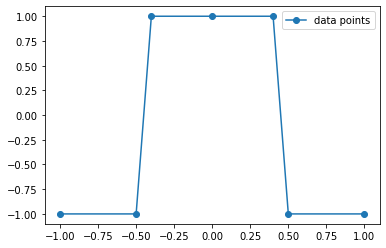

In [11]:
Nmin=-1
Nmax=1
N=7

class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = {'data': float(self.data[idx]), 'label': self.label[idx]}
        return sample

    
def fun(x):
    return np.sin(x*np.pi)


data=np.array([-1,-0.5,-0.4,0,0.4,0.5,1])*1.0
label=np.array([0,0,1,1,1,0,0])*2.0-1

train_data=data
train_label=label

plt.plot(train_data,train_label,'-o',label='data points')
plt.legend()
plt.savefig('data_points.png')

train_loader = torch.utils.data.DataLoader(dataset=MyDataset(train_data,train_label), 
                                           batch_size=N, 
                                           shuffle=False)

device = torch.device('cuda')

In [12]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 1

hidden_size1 = 10000

num_classes = 1

class NeuralNet2layer(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes, initialize='NTK',batchnorm=False):
        super(NeuralNet2layer, self).__init__()
        self.initialize=initialize
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.batchnorm = batchnorm


        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)


        if self.batchnorm:
            self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        
        if self.initialize=='NTK':

            self.fc1.weight.detach().uniform_(-1, 1)
            self.fc1.bias.detach().uniform_(-1, 1)
            self.fc2.weight.detach().uniform_(-1,1)




    def forward(self, x):
        if self.batchnorm:
            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
        else:

            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.relu1(out)
                out = self.fc2(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
        return out

In [13]:
def plot_training(model,node_num=1000):
    plt.plot(train_data,train_label,'x',label=r'$x_j,y_j$')

    
    x= np.linspace(Nmin, Nmax, num=node_num)
    y= np.zeros(node_num)
    with torch.no_grad():
        for i in range(node_num):
            xx=torch.tensor(x[i]).reshape(-1, 1).to(device).float()
            y[i]=model(xx).to(device).cpu().numpy()
    plt.plot(x,y,'-',label=r'$x,f(x)$')
 

In [14]:
def mofi_one(record_i,ia=None,ib=None,beta=1,learning_rate=0.2,epoch=10000,dev=100):
    dev=dev
    traj=[]
    beta=beta
    learning_rate = learning_rate
    torch.manual_seed(0)
    batchnorm=False
    device = torch.device('cuda')
    model = NeuralNet2layer(input_size, hidden_size1,num_classes, initialize='NTK',batchnorm=False).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    outdis = display(progress(0, 100), display_id=True)


    with torch.no_grad():
        if ia !=None:
            model.fc1.weight[record_i][0]=ia
        if ib !=None:
            model.fc1.bias[record_i]=ib
        model.fc1.weight[record_i][0]=model.fc1.weight[record_i][0]/beta
        model.fc1.bias[record_i]=model.fc1.bias[record_i]/beta
        model.fc2.weight[0][record_i]=model.fc2.weight[0][record_i]*beta


    for i, data in enumerate(train_loader):
        pass
    images = data['data'].reshape(-1, 1).to(device).float()
    labels = data['label'].reshape(-1, 1).to(device).float()
    




    for runsteps in range(epoch):
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()


        if runsteps==1000 or runsteps==10000 or runsteps==100000:
            learning_rate = learning_rate * 10
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)


        if runsteps% dev==0:
            outdis.update(progress(outdis.update(progress(100.*runsteps/epoch, 100)), 100))
            with torch.no_grad():
                x=-model.fc1.bias[record_i]/model.fc1.weight[record_i][0].reshape(-1, 1).to(device).float()
                traj.append([x,model(x)])

        if lo<0.001:
            break
    return torch.tensor(traj),model

In [ ]:
#for beta in [0.01,0.05,0.1,0.5,1,1.5]:
#for beta in [0.1,0.2,0.3,0.4,0.5]:
trajlist=[]
for beta in [0.5,1,1.5,2,3.5]:

    traj,model=mofi_one(1,ia=-0.5,ib=0.08,beta=beta,learning_rate=0.000001,epoch=1000000,dev=10)
    traj=traj.cpu()
    trajlist.append(traj)
    if beta==1:
        keepmodel=copy.deepcopy(model)
    plt.plot(traj[:,0],traj[:,1],label=r'$\beta=$'+str(beta))

plot_training(model)
plt.legend()

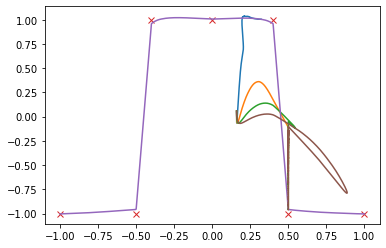

In [24]:
plt.plot(trajlist[0][:,0],trajlist[0][:,1],label=1)
plt.plot(trajlist[1][:,0],trajlist[1][:,1],label=1)
plt.plot(trajlist[2][:,0],trajlist[2][:,1],label=1)
plot_training(model)
plt.plot(trajlist[3][:,0],trajlist[3][:,1],label=1)

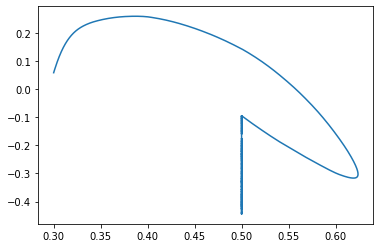

In [ ]:
plt.plot(traj[:,0],traj[:,1])

In [ ]:
traj

tensor([[0.4000, 0.0805],
        [0.4000, 0.4178],
        [0.3996, 0.4034],
        ...,
        [0.3912, 1.0214],
        [0.3913, 1.0214],
        [0.3913, 1.0214]])